In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifelines import WeibullFitter, CoxTimeVaryingFitter

# 1. 定义列名（C-MAPSS 标准格式）
# 前两列是：引擎ID、运行周期
# 接下来3列是：操作设置
# 最后21列是：传感器读数
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['SM{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

# 2. 读取数据
# 假设你的文件路径是在 CMAPSSData 文件夹下
file_path = 'CMAPSSData/train_FD001.txt'

try:
    df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)
    print(f"成功读取文件: {file_path}")
    print(f"总数据行数: {len(df)}")
except FileNotFoundError:
    print(f"错误: 找不到文件 {file_path}，请确认路径是否正确。")
    # 如果你在本地运行，请确保路径对应
    df = pd.DataFrame() # 空防止报错

# 3. 筛选出“第 9 号发动机”的数据
if not df.empty:
    engine_id = 9
    df_engine_9 = df[df['unit_nr'] == engine_id]
    
    print(f"\n--- 第 {engine_id} 号发动机数据概况 ---")
    print(f"该引擎运行周期数: {len(df_engine_9)}")
    
    # 4. 计算统计量 (复现论文 Table 1)
    # 只选择传感器列
    sensor_data = df_engine_9[sensor_names]
    
    # 计算 Mean, STD, Min, Max
    stats = sensor_data.agg(['mean', 'std', 'min', 'max']).T
    
    # 5. 格式化输出（保留2位小数，与论文对齐）
    stats = stats.round(2)
    
    # 为了方便对比，我们可以把 STD 为 0.00 的显示得更清楚
    # 论文中 Mean, STD, Min, Max 是列
    print("\n--- 复现结果 (与论文 Table 1 对比) ---")
    print(stats)


d:\Anaconda\envs\python3.10.11\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


成功读取文件: CMAPSSData/train_FD001.txt
总数据行数: 20631

--- 第 9 号发动机数据概况 ---
该引擎运行周期数: 201

--- 复现结果 (与论文 Table 1 对比) ---
         mean    std      min      max
SM1    518.67   0.00   518.67   518.67
SM2    642.40   0.48   641.41   644.04
SM3   1588.31   6.11  1574.30  1607.04
SM4   1403.03   8.68  1386.43  1433.83
SM5     14.62   0.00    14.62    14.62
SM6     21.61   0.00    21.60    21.61
SM7    554.07   0.69   551.71   555.66
SM8   2388.02   0.06  2387.94  2388.50
SM9   9093.47  39.96  9051.59  9239.76
SM10     1.30   0.00     1.30     1.30
SM11    47.34   0.23    46.88    48.11
SM12   522.03   0.61   519.86   523.12
SM13  2388.01   0.07  2387.88  2388.56
SM14  8170.73  33.07  8140.94  8289.63
SM15     8.42   0.03     8.35     8.53
SM16     0.03   0.00     0.03     0.03
SM17   392.51   1.65   389.00   399.00
SM18  2388.00   0.00  2388.00  2388.00
SM19   100.00   0.00   100.00   100.00
SM20    38.91   0.16    38.39    39.27
SM21    23.35   0.11    23.02    23.53


### 1. 数据加载与传感器挑选

In [2]:
# ==========================================
# 1. 加载全量数据 (FD001)
# ==========================================
# 列名定义
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['SM{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

# 读取数据 (请确保路径正确)
file_path = 'CMAPSSData/train_FD001.txt'
df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)

print(f"数据加载完成: {df.shape}")

# ==========================================
# 2. 传感器选择 (Paper Section 4.1)
# ==========================================
# 论文原文："only 14 sensors were selected... SM2, SM3, SM4, SM7, SM8, SM9, SM11, SM12, SM13, SM14, SM15, SM17, SM20, SM21"
selected_features = ['SM2', 'SM3', 'SM4', 'SM7', 'SM8', 'SM9', 'SM11', 
                     'SM12', 'SM13', 'SM14', 'SM15', 'SM17', 'SM20', 'SM21']

# 只保留 ID, 时间 和 选中的传感器
df_process = df[index_names + selected_features].copy()



数据加载完成: (20631, 26)


### 2. 全局归一化

In [3]:
# ==========================================
# 3. 归一化 (Paper Eq 1)
# ==========================================
# 论文原文：X' = (X - min) / (max - min)
scaler = MinMaxScaler()
df_process[selected_features] = scaler.fit_transform(df_process[selected_features])

print("归一化完成 (MinMax Scaling)")



归一化完成 (MinMax Scaling)


### 3. 构建 Lifelines 长格式

In [4]:
# ==========================================
# 4. 构建 Lifelines 格式 (Long Format)
# ==========================================
# CoxTimeVaryingFitter 需要：id, start, stop, event

# 4.1 构造 start 和 stop
# C-MAPSS 是离散的时间点 (1, 2, 3...)
# start = t-1, stop = t
df_process['start'] = df_process['time_cycles'] - 1
df_process['stop'] = df_process['time_cycles']



### 4. 构造事件标签

In [5]:
# 4.2 构造 Event (E)
# 这是一个 Run-to-Failure 数据集。
# 对于每个引擎，只有在它的“最大周期”那一刻，E=1 (失效)，之前全是 E=0 (右删失/存活)

# 计算每个引擎的最大寿命
max_cycles = df_process.groupby('unit_nr')['time_cycles'].max()

def get_event(row):
    # 如果当前时间 == 该引擎的最大寿命，则标记为失效 (1)
    if row['time_cycles'] == max_cycles[row['unit_nr']]:
        return 1
    else:
        return 0

df_process['E'] = df_process.apply(get_event, axis=1)

print(f"数据转换完成。样本数: {len(df_process)}, 引擎数: {df_process['unit_nr'].nunique()}")
print(df_process[['unit_nr', 'start', 'stop', 'E'] + selected_features[:2]].head())



数据转换完成。样本数: 20631, 引擎数: 100
   unit_nr  start  stop  E       SM2       SM3
0        1      0     1  0  0.183735  0.406802
1        1      1     2  0  0.283133  0.453019
2        1      2     3  0  0.343373  0.369523
3        1      3     4  0  0.343373  0.256159
4        1      4     5  0  0.349398  0.257467


### 5.  Weibull 基线风险拟合

In [6]:
# ==========================================
# 5. 复现 Baseline Hazard (Weibull)
# Paper Section 4.2 Eq (4)
# ==========================================
print("\n--- 模型 1: Weibull 基线风险拟合 ---")

# 提取失效时间数据 (每个引擎只取最后一行，代表它的寿命)
# 因为所有引擎最后都坏了，所以 E 全是 1
lifetimes = max_cycles.values
event_observed = np.ones_like(lifetimes) 

wb = WeibullFitter()
wb.fit(lifetimes, event_observed)

print(f"拟合结果:")
print(f"Shape (beta) : {wb.rho_:.4f}  (论文值: 4.409)")
print(f"Scale (eta)  : {wb.lambda_:.4f} (论文值: 225.026)")

# 简单验证
if abs(wb.rho_ - 4.409) < 0.5:
    print("✅ Beta 参数接近论文结果")
else:
    print("⚠️ Beta 参数有一定偏差 (正常，受拟合方法差异影响)")

# ==========================================
# 6. 复现 Hazard Risk (Time-Varying Cox)



--- 模型 1: Weibull 基线风险拟合 ---
拟合结果:
Shape (beta) : 4.4087  (论文值: 4.409)
Scale (eta)  : 225.0259 (论文值: 225.026)
✅ Beta 参数接近论文结果


### 6. Cox 时变模型拟合

In [14]:
# Paper Table 2
# ==========================================
print("\n--- 模型 2: 时变 Cox (Hazard Risk) 拟合 ---")

# 实例化模型
# 注意：C-MAPSS 传感器共线性很强，如果不收敛可能需要加 penalizer (如 0.1)
ctv = CoxTimeVaryingFitter(penalizer=0.0) 

# 【关键修复】先筛选 DataFrame，只保留拟合需要的列
# CoxTimeVaryingFitter 会把除 id/start/stop/event 外的所有列当作协变量
required_cols = ['unit_nr', 'start', 'stop', 'E'] + selected_features
df_fit = df_process[required_cols].copy()

# 拟合 (移除 columns 参数)
ctv.fit(df_fit, 
        id_col='unit_nr', 
        event_col='E', 
        start_col='start', 
        stop_col='stop',
        show_progress=True)

# 输出系数表
print("\n复现的系数表 (Top 5 关键变量):")
summary = ctv.summary[['coef', 'exp(coef)', 'p']]
print(summary)

print("\n--- 与论文 Table 2 对比 ---")
# 选取几个论文中系数较大的特征进行对比
comparison = {
    'SM2': 1.424,
    'SM3': 0.021, 
    'SM4': 0.145,
    'SM7': -0.898,
    'SM8': -1.698, 
    'SM9': -0.010,
    'SM11': 4.497,
    'SM12':-1.647, 
    'SM13': 6.201, 
    'SM14': 0.026,
    'SM15': 3.394, 
    'SM17': 0.245,
    'SM20': -4.873, 
    'SM21': -3.720
}

for sensor, paper_val in comparison.items():
    if sensor in summary.index:
        my_val = summary.loc[sensor, 'coef']
        print(f"{sensor}: 我的复现 = {my_val:.3f}, 论文 = {paper_val}")
    else:
        print(f"{sensor}: 未找到")




--- 模型 2: 时变 Cox (Hazard Risk) 拟合 ---
Iteration 1: norm_delta = 1.00e+00, step_size = 0.9500, log_lik = -363.73938, newton_decrement = 1.69e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.23e+00, step_size = 0.9500, log_lik = -196.95744, newton_decrement = 6.53e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.49e-01, step_size = 0.9500, log_lik = -141.32406, newton_decrement = 2.53e+01, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.27e-01, step_size = 0.9310, log_lik = -129.43964, newton_decrement = 1.68e+01, seconds_since_start = 0.0
Iteration 5: norm_delta = 2.30e-01, step_size = 1.0000, log_lik = -115.92018, newton_decrement = 1.13e+00, seconds_since_start = 0.0
Iteration 6: norm_delta = 4.04e-02, step_size = 1.0000, log_lik = -114.78357, newton_decrement = 1.24e-02, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.62e-04, step_size = 1.0000, log_lik = -114.77107, newton_decrement = 2.21e-06, seconds_since_start = 0.1
Iteration 8: norm_delta = 1.18

### 7. Hazard Rate 重现


--- Step 7: 计算最终 Hazard Rate (复现 Eq.3 & Fig.1) ---


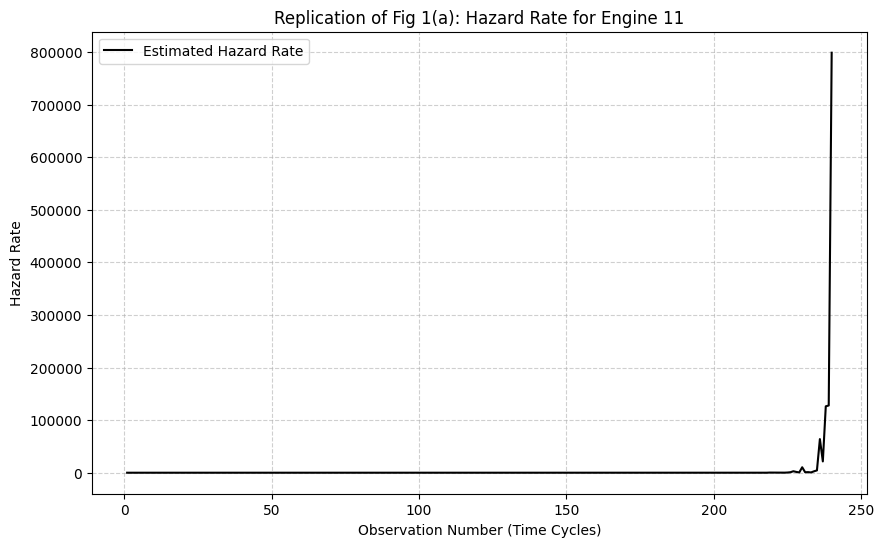

Engine 11 的 Hazard Rate 计算完成。
如果曲线呈指数上升趋势，说明复现成功。


In [8]:

# ==========================================
# 7. 终极复现：计算 Hazard Rate (Paper Eq 3)
# h(t, Z) = h0(t) * exp(beta * Z)
# ==========================================
print("\n--- Step 7: 计算最终 Hazard Rate (复现 Eq.3 & Fig.1) ---")

# 1. 获取 Weibull 参数 (来自模型 1)
beta = wb.rho_
eta = wb.lambda_

# 2. 计算 Baseline Hazard h0(t)
# 公式: (beta/eta) * (t/eta)^(beta-1)
# 注意：我们要对原始数据的每一行都算这个值
t = df_process['time_cycles']
h0_t = (beta / eta) * (t / eta)**(beta - 1)

# 3. 计算 Hazard Risk exp(∑λZ) (来自模型 2)
# ctv.predict_partial_hazard(x) 计算的就是 exp(partial_log_hazard)
# 这就是公式里的 exp(∑λZ) 部分
hazard_risk = ctv.predict_partial_hazard(df_process)

# 4. 组合得到最终 Hazard Rate
# Eq (3): h(t,Z) = h0(t) * Hazard_Risk
df_process['hazard_rate'] = h0_t * hazard_risk

# --- 可视化验证 (复现 Fig 1.a) ---
# 论文画的是第 11 号引擎 (Engine 11)
engine_id = 11
subset = df_process[df_process['unit_nr'] == engine_id]

plt.figure(figsize=(10, 6))
plt.plot(subset['time_cycles'], subset['hazard_rate'], color='black', label='Estimated Hazard Rate')
plt.title(f"Replication of Fig 1(a): Hazard Rate for Engine {engine_id}")
plt.xlabel("Observation Number (Time Cycles)")
plt.ylabel("Hazard Rate")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

print(f"Engine {engine_id} 的 Hazard Rate 计算完成。")
print("如果曲线呈指数上升趋势，说明复现成功。")